# Question A3

Find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Question 1 and 2

#### Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

This might take a while to run, approximately 20 - 30 min, so plan your time carefully.

1. Firstly, we import relevant libraries.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import *

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [2]:
# YOUR CODE HERE
# YOUR CODE HERE
from common_utils import MLP
from common_utils import CustomDataset
from common_utils import loss_fn
from common_utils import split_dataset, preprocess_dataset
from common_utils import EarlyStopper
from datetime import datetime

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

df['label'].value_counts()

X_train, y_train, X_test, y_test = split_dataset(df, ['filename', 'label'], 0.3, 0)
X_train

,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,melspectrogram_mean,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
11631,107.666016,2446,174.714286,0.581436,0.070376,0.455908,0.086070,0.255325,0.018142,0.024780,...,-5.770311,101.961494,0.726778,65.895195,-0.372497,59.756054,-2.990087,48.541611,-2.369126,74.494980
6619,117.453835,1919,147.615385,0.570992,0.068214,0.533140,0.067908,0.270572,0.010124,0.023933,...,-2.420724,72.575821,0.157023,89.650146,-3.008414,66.569794,-0.562329,61.818340,3.631580,86.445297
1257,135.999178,3866,193.300000,0.665871,0.064646,0.575811,0.055166,0.274959,0.007731,0.171105,...,-0.276058,79.474617,2.507980,64.289543,2.488033,57.481800,0.371860,56.641167,0.653117,58.880585
7611,103.359375,184,46.000000,0.581547,0.076387,0.457474,0.070914,0.260429,0.015510,0.116615,...,-3.115304,87.528542,-4.961778,104.891090,4.375006,73.968193,0.428776,61.100105,-1.731462,44.836227
4665,71.777344,261,65.250000,0.554061,0.081497,0.491283,0.079467,0.261753,0.014819,0.009013,...,-7.038899,53.558556,-2.577223,57.261269,-3.824014,46.565659,-6.141013,50.087326,-1.887392,59.745602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4859,143.554688,901,90.100000,0.478259,0.096148,0.438220,0.092903,0.259968,0.015750,0.065788,...,-10.744453,77.242554,-5.778560,78.063904,-3.756855,57.650112,-6.038925,56.642426,-6.883427,68.010582
3264,107.666016,11359,366.419355,0.528170,0.089229,0.514248,0.072142,0.270735,0.010036,0.002701,...,-10.639221,85.417351,1.240076,63.720001,2.164308,57.301521,-5.378757,62.188622,3.131972,60.999619
9845,103.359375,455,75.833333,0.564319,0.094585,0.384832,0.061052,0.249539,0.021064,0.015486,...,-1.354200,46.093472,2.588070,63.986980,4.225698,56.400631,-0.810466,73.712036,0.072680,76.151619
10799,103.359375,4591,241.631579,0.721832,0.041792,0.531015,0.067686,0.259324,0.016084,0.031883,...,-4.262617,65.467903,-0.299933,61.815067,8.531980,61.917839,-0.106459,49.114147,3.769001,52.739552


3. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [3]:
def train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size):
    # YOUR CODE HERE
    train_accuracies, train_losses, test_accuracies, test_losses, times = [], [], [], [], []
    train_data = CustomDataset(X_train_scaled, y_train2)
    val_data = CustomDataset(X_val_scaled, y_val2)
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    no_epoch = 100
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    early_stopper = EarlyStopper(patience=3, min_delta=0)
    for epoch in range(no_epoch):
        start_time = datetime.now()
        train_loss, correct = 0, 0
        size = len(train_dataloader.dataset)
        for batch, (x_train,y_train) in enumerate(train_dataloader):
            pred = model(x_train)
            loss = loss_fn(pred, y_train)

            optimizer.zero_grad()
            loss.backward() 
            optimizer.step() 

            train_loss += loss.item()
            correct += (pred.argmax(1) == y_train).type(torch.float).sum().item()

        train_loss /= size
        correct /= size
        train_losses.append(train_loss)
        train_accuracies.append(correct)

        size = len(val_dataloader.dataset)
        test_loss, correct = 0, 0

        with torch.no_grad():
            for x_val, y_val in val_dataloader:
                pred = model(x_val)
                test_loss += loss_fn(pred, y_val).item()
                correct += (pred.argmax(1) == y_val).type(torch.float).sum().item()

        test_loss /= size
        correct /= size

        test_accuracies.append(correct)
        test_losses.append(test_loss)

        end_time = datetime.now()
        elapsed_time = end_time - start_time

        if early_stopper.early_stop(test_loss):
            print("Done!")
            times.append(elapsed_time.microseconds/1000000)
            break
        if epoch == no_epoch-1:
            times.append(elapsed_time.microseconds/1000000)


    return train_accuracies, train_losses, test_accuracies, test_losses, times

In [4]:

def find_optimal_hyperparameter(X_train, y_train, parameters, mode, batch_size):
    X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_batch_sizes([batch_size], X_train, y_train)
    cross_validation_accuracies, cross_validation_times = [], []
    early_stopper = EarlyStopper(patience=3, min_delta=0)
    for num_neurons in parameters:
        print()
        print("Num of Neurons: " + str(num_neurons))

        model = MLP(77,128,2,num_neurons)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        fold_acc = []
        fold_time = []
        for fold in range(5):
            X_train_scaled = X_train_scaled_dict[batch_size][fold]
            y_train2 = y_train_dict[batch_size][fold]
            X_val_scaled = X_val_scaled_dict[batch_size][fold]
            y_val2 = y_val_dict[batch_size][fold]
           
            train_accuracies, train_losses, test_accuracies, test_losses, times = train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size)
            fold_time.append(np.mean(np.array(times), axis=0))
            print("fold " + str(fold) + ":" + str(test_accuracies[len(test_accuracies)-1]))
            fold_acc.append(test_accuracies[len(test_accuracies)-1])
        
        cross_validation_times.append(np.mean(np.array(fold_time), axis = 0))
        cross_validation_accuracies.append(np.mean(np.array(fold_acc), axis = 0))
    return cross_validation_accuracies, cross_validation_times


optimal_bs = 128

# YOUR CODE HERE
num_neurons = [64, 128, 256]
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train.to_numpy(), y_train, num_neurons, 'num_neurons', optimal_bs)


Num of Neurons: 64
Done!
fold 0:0.6404028436018957
Done!
fold 1:0.7103080568720379
Done!
fold 2:0.7316350710900474
Done!
fold 3:0.7257109004739336
Done!
fold 4:0.7557794902193242

Num of Neurons: 128
Done!
fold 0:0.6718009478672986
Done!
fold 1:0.7796208530805687
Done!
fold 2:0.7754739336492891
Done!
fold 3:0.7772511848341233
Done!
fold 4:0.7949021932424422

Num of Neurons: 256
Done!
fold 0:0.6854265402843602
Done!
fold 1:0.7748815165876777
Done!
fold 2:0.8027251184834123
Done!
fold 3:0.8122037914691943
Done!
fold 4:0.8429164196799052


4. Plot the cross-validation accuracies against the number of epochs for different numbers of hidden-layer neurons. Limit the search space of the number of neurons to {64, 128, 256}.

Text(0, 0.5, 'cross-validation accuracy')

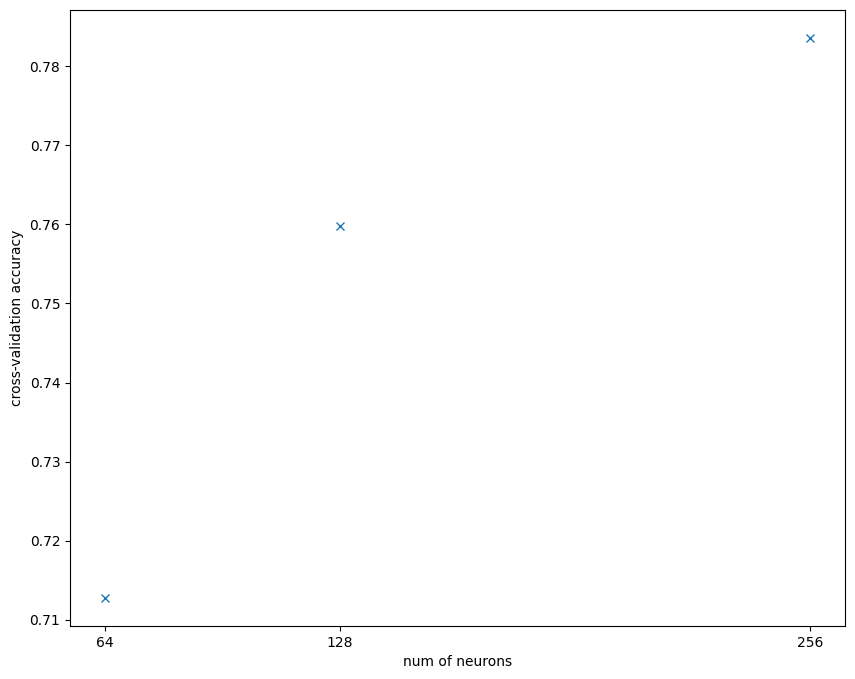

In [5]:
# YOUR CODE HERE
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(num_neurons, cross_validation_accuracies, marker = 'x', linestyle = 'None')
plt.xticks(num_neurons)
plt.xlabel('num of neurons')
plt.ylabel('cross-validation accuracy')

5. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [6]:
optimal_neurons = 256
reason = "256 number of neurons for the first hidden layer of the network gives the best mean CV accuracy, hence 256 was selected for optimal number of neurons"
# YOUR CODE HERE

6. Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.

Done!


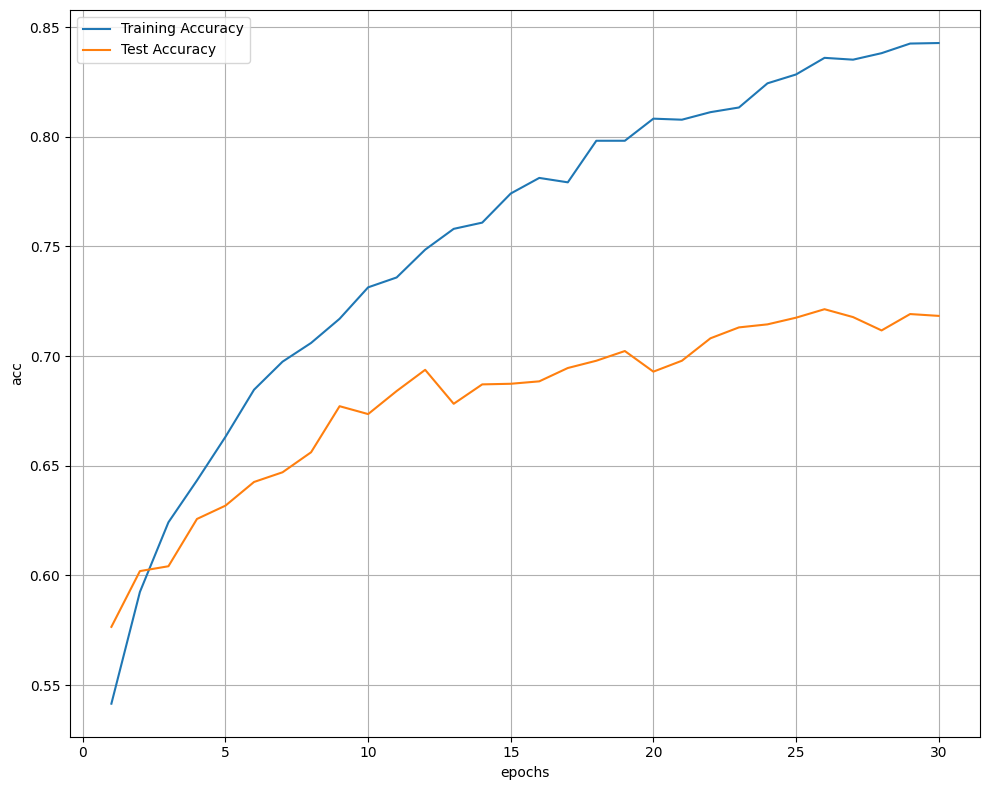

In [9]:
# YOUR CODE HERE
model = MLP(77,128,2,optimal_neurons)
X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)
train_accuracies, train_losses, test_accuracies, test_losses, times = train(model, X_train_scaled, y_train, X_test_scaled, y_test, optimal_bs)

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_accuracies)+1),train_accuracies, label='Training Accuracy')
plt.plot(range(1,len(test_accuracies)+1),test_accuracies,label='Test Accuracy')

plt.xlabel('epochs')
plt.ylabel('acc')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()